In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial as sp
import random

In [2]:
data = list ()
with open ("a280.tsp", "r") as file:
    for line in file.readlines ()[6:-1]:
        data.append ([int (val) for val in line.strip("\n").split ()[1:]])

df = pd.DataFrame (data, columns=["x", "y"], index = range (1, len (data) + 1))
distance_matrix = pd.DataFrame (sp.distance_matrix (df.values, df.values), index = df.index, columns = df.index)

In [3]:
class Gene:
    def __init__(self, set_data : bool = True) -> None:
        self.data = list ()
        if set_data:
            self.data = random.sample (data, len (data))

class Individual (Gene):
    def __init__(self, new_data : list = None) -> None:
        pre_set_data = new_data is None
        super().__init__(pre_set_data)
        if not pre_set_data:
            self.data = new_data
        self.calculate_distance ()
        if self.distance != 0:
            self.fitness = 1 / self.distance

    def calculate_distance (self):
        if len (self.data) != len (data):
            raise ("self data range error")
        self.distance = np.sum ([distance_matrix[data.index (self.data[i]) + 1][data.index (self.data[i + 1]) + 1] for i in range (len (data) - 1)])

    def mutate (self, mutation_rate : float) -> None:
        mutated_data = self.data
        for node_a in range (len (self.data)):
            if (random.random () < mutation_rate):
                node_b = int (random.random () * len (self.data))

                node_a_data = self.data[node_a]
                node_b_data = self.data[node_b]

                mutated_data[node_a] = node_b_data
                mutated_data[node_b] = node_a_data
        self.data = mutated_data

    @classmethod
    def breed (cls, parent_a, parent_b, crossover : float , mutation_rate : float) -> None:
        child = list ()
        c = int (crossover * len (parent_a.data))
        while len (child) != len (data):
            start = int(random.random() * len(parent_a.data) - c)
            end = start + c

            child = parent_a.data[start:end] + [item for item in parent_b.data if item not in parent_a.data[start:end]]

        child = cls (child)
        child.mutate (mutation_rate)

        return [child]

In [4]:
class Population:
    def __init__(self, population_size : int = 10, crossover : float = 0.3, mutation_rate : float = 0.1) -> None:
        self.generation = 0
        self.population_size = population_size
        self.crossover = crossover
        self.mutation_rate = mutation_rate
        self.elite_size = int (population_size * 0.1)
        self.children = list ()
        self.parents = [Individual () for _ in range (population_size)]
        self.parents.sort (key = lambda parent: parent.distance, reverse = True)
        self.end = False

    def selection (self) -> list:
        selections = list ()
        ranked_population = [[i, self.parents[i].fitness] for i in range (self.population_size)]
        ranked_population.sort (key = lambda item: item[1], reverse = True)
        df = pd.DataFrame (np.array (ranked_population), columns = ["Index", "Fitness"])
        df["cum_sum"] = df.Fitness.cumsum ()
        df["cum_perc"] = 100 * df.cum_sum / df.Fitness.sum ()

        for i in range (self.elite_size):
            selections.append (ranked_population[i][0])

        for i in range (len (ranked_population) - self.elite_size):
            pick = 100 * random.random ()
            for i in range (len (ranked_population)):
                if pick <= df.iat[i, 3]:
                    selections.append (ranked_population[i][0])
                    break

        return [self.parents[index] for index in selections]

    def breed (self) -> None:
        mating_pool = self.selection ()
        length = len (mating_pool) - self.elite_size
        pool = random.sample (mating_pool, len (mating_pool))

        for i in range (self.elite_size):
            self.children.append (mating_pool[i])

        for i in range (length):
            children = Individual.breed (pool[i], pool[len (mating_pool) - i - 1], self.crossover, self.mutation_rate)
            self.children.extend (children)

        if len (self.children) != 0:
            self.children.sort (key = lambda child: child.distance, reverse = True)
            self.parents = self.children[:self.population_size]
            self.children = list ()
            self.generation += 1
        else:
            self.end = True
            print ("No children")

In [5]:
def gaRunner (population_size : int, crossover : float, mutation_rate : float, limit : int):
    generations = list ()
    distance = list ()
    pop = Population (population_size = population_size, crossover = crossover, mutation_rate = mutation_rate)
    optimum = pop.parents[0]
    while not pop.end and pop.generation <= limit:
        if pop.generation % 10 == 0:
            generations.append (pop.generation)
            distance.append (pop.parents[0].distance)
            if optimum.distance > pop.parents[0].distance:
                optimum = pop.parents[0]
            print ("gen: {:05d}".format (pop.generation), "\t"*5, "dis: {:0.4f}".format (pop.parents[0].distance), "\t"*5, "Min dis: {:0.4f}".format (optimum.distance))
        pop.breed ()

    return generations, distance, optimum

In [8]:
generations, distance, optimum = gaRunner (population_size = 100, crossover = 0.4, mutation_rate = 0.001, limit = 1000)

gen: 00000 					 dis: 36278.7081 					 Min dis: 36278.7081
gen: 00010 					 dis: 34863.3205 					 Min dis: 34863.3205
gen: 00020 					 dis: 32411.5070 					 Min dis: 32411.5070
gen: 00030 					 dis: 30098.9223 					 Min dis: 30098.9223
gen: 00040 					 dis: 29747.1749 					 Min dis: 29747.1749
gen: 00050 					 dis: 28366.9143 					 Min dis: 28366.9143
gen: 00060 					 dis: 28165.3130 					 Min dis: 28165.3130
gen: 00070 					 dis: 26793.7509 					 Min dis: 26793.7509
gen: 00080 					 dis: 25747.3253 					 Min dis: 25747.3253
gen: 00090 					 dis: 26007.7327 					 Min dis: 25747.3253
gen: 00100 					 dis: 26162.8012 					 Min dis: 25747.3253
gen: 00110 					 dis: 24484.0970 					 Min dis: 24484.0970
gen: 00120 					 dis: 24484.7184 					 Min dis: 24484.0970
gen: 00130 					 dis: 24242.1262 					 Min dis: 24242.1262
gen: 00140 					 dis: 24190.6487 					 Min dis: 24190.6487
gen: 00150 					 dis: 23138.4671 					 Min dis: 23138.4671
gen: 00160 					 dis: 24534.9225 					 Min dis: 23138.46

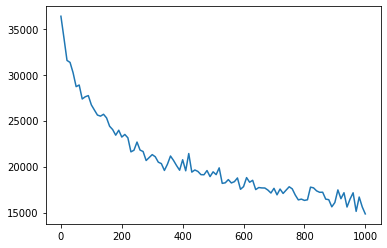

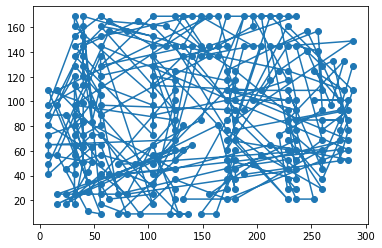

In [ ]:
plt.figure ()
plt.plot (generations, distance)

plt.figure ()
plt.scatter ([d[0] for d in optimum.data], [d[1] for d in optimum.data])
plt.plot ([d[0] for d in optimum.data], [d[1] for d in optimum.data])